In [1]:
from ydata_profiling import ProfileReport
import pandas as pd
import webbrowser
import os
import re
from IPython.display import display
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.punkt import PunktSentenceTokenizer
from nltk.data import load as nltk_load
from langdetect import detect, DetectorFactory
import pygwalker as pyg
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kruskal

In [2]:
# Set base_dir as current working directory
# Paths
base_dir = os.getcwd()
input_path = os.path.join(base_dir, "input", "dataset_rflect.xlsx")
output_dir = os.path.join(base_dir, "output")
os.makedirs(output_dir, exist_ok=True)

# Local nltk_data folder
nltk_data_path = os.path.join(os.getcwd(), "nltk_data")
os.makedirs(nltk_data_path, exist_ok=True)

# Set nltk path and download punkt (will only download if missing)
nltk.data.path.insert(0, nltk_data_path)
nltk.download("punkt", download_dir=nltk_data_path)

# Load dataset
df = pd.read_excel(input_path)


[nltk_data] Downloading package punkt to /Users/sabinewildemann/Docume
[nltk_data]     nts/A_EGO/2_Studium/1_Forschungsprojekt/FDA93SPIII4/nl
[nltk_data]     tk_data...
[nltk_data]   Package punkt is already up-to-date!


### Profiling report

In [3]:
""" # Generate and save profile
profile = ProfileReport(df, title="Rflect Student Reflections - Data Profile", explorative=True)
html_path = os.path.join(output_dir, "rflect_data_profile.html")
profile.to_file(html_path)
profile.to_notebook_iframe()

# Open HTML in browser
webbrowser.open(f"file://{html_path}")

print(f"✅ HTML report saved and opened.\n") """

' # Generate and save profile\nprofile = ProfileReport(df, title="Rflect Student Reflections - Data Profile", explorative=True)\nhtml_path = os.path.join(output_dir, "rflect_data_profile.html")\nprofile.to_file(html_path)\nprofile.to_notebook_iframe()\n\n# Open HTML in browser\nwebbrowser.open(f"file://{html_path}")\n\nprint(f"✅ HTML report saved and opened.\n") '

In [4]:
# 3.2 Data Integration
# Reorder columns for consistent structure and compute additional character-based fields.
# calc_refl_snap: actual character count of reflection_snapshot
# calc_final_refl: actual character count of final_reflection
# calc_ai_suggest_length: actual character count of suggestion_content
# These fields support cross-checking against metadata (snapshot_length, content_length)
# and serve as a consistent base for later feature engineering and hypothesis testing.

desired_order = [
    "topic_title",
    "topic_description",
    "question",
    "reflection_snapshot",
    "snapshot_length",
    "suggestion_content",
    "final_reflection",
    "content_length",
    "length_diff",
    "created_at",
    "last_reflection_moment",
    "seconds_spent",
    "suggestion_params"
]
df = df[desired_order]

# Add calculated fields
df["calc_ai_suggest_length"] = df["suggestion_content"].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)
df["calc_refl_snap"] = df["reflection_snapshot"].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)
df["calc_final_refl"] = df["final_reflection"].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)

# Reorder to place calculated fields in new desired positions
cols = df.columns.tolist()

# Insert 'calc_ai_suggest_length' after 'suggestion_content'
cols.insert(cols.index("suggestion_content") + 1, cols.pop(cols.index("calc_ai_suggest_length")))

# Insert 'calc_refl_snap' after 'snapshot_length'
cols.insert(cols.index("snapshot_length") + 1, cols.pop(cols.index("calc_refl_snap")))

# Insert 'calc_final_refl' after 'content_length'
cols.insert(cols.index("content_length") + 1, cols.pop(cols.index("calc_final_refl")))

# Apply final order
df = df[cols]

# Display to verify
df.head()

,topic_title,topic_description,question,reflection_snapshot,snapshot_length,calc_refl_snap,suggestion_content,calc_ai_suggest_length,final_reflection,content_length,calc_final_refl,length_diff,created_at,last_reflection_moment,seconds_spent,suggestion_params
0,Openness & Learning Mindset 4,NaN,<p>Reflect on a time when you had to step out ...,"In the last few months, there was a reorganiza...",1423,1423,Your reflection shows great insight into your ...,338,"In the last few months, there was a reorganiza...",1423,1423,0,2025-01-25 18:02:56.651079 +00:00,2025-01-25 18:02:52.252599 +00:00,3,"{""model"": ""gpt-4o-mini"", ""prompt"": ""Imagine, a..."
1,#2 + #3 Preparing project proposals,<p></p>,What do you consider the biggest risks to the ...,NaN,0,0,It seems like you forgot to include the studen...,138,Mangelender Zusammenhalt der Gruppe / Unfaire ...,160,160,160,2024-10-03 12:47:48.280589 +00:00,2024-10-03 12:49:08.830189 +00:00,68,"{""model"": ""gpt-4o-mini"", ""prompt"": ""Imagine, a..."
2,#2 + #3 Preparing project proposals,<p></p>,<p>Discuss your personal learning goals within...,NaN,0,0,It's great to see you engaging with your learn...,278,"Mein Ziel in diesem Projekt ist es, mehr über ...",681,681,681,2025-03-10 09:26:18.605255 +00:00,2025-03-10 09:31:22.738632 +00:00,65,"{""model"": ""gpt-4o-mini"", ""prompt"": ""Imagine, a..."
3,#10 Self-awareness | IDG Competence,"<p style=""text-align:justify"">This competence ...",What advice would your best friends give you f...,"Für diese Übung habe ich die Person angefragt,...",154,151,"Es ist großartig, dass du deine Schwester um F...",246,"Für diese Übung habe ich die Person angefragt,...",356,353,202,2024-11-20 10:25:47.608211 +00:00,2024-11-20 10:27:24.736311 +00:00,180,"{""model"": ""gpt-4o-mini"", ""prompt"": ""Imagine, a..."
4,Persönliche Lernziele setzen,<p>Wenn Sie sich Ihre eigenen Lernziele für di...,"<p>Stellen Sie sich vor, Sie hätten <strong>mi...",Dass eine kollaborative Einstellung seitens Te...,150,150,"Es ist großartig, dass du die Bedeutung der Zu...",353,Eine kollaborative Einstellung seitens Team un...,366,366,216,2025-02-24 13:34:44.611436 +00:00,2025-02-24 13:36:54.932848 +00:00,180,"{""model"": ""gpt-4o-mini"", ""prompt"": ""Imagine, a..."


### Analysis data

In [5]:
# The profiling report shows only 268 distinct data entries (of 300). After analysis it's decided to keep only the most recent entry and drop the other duplicates.

# Filter out rows with missing final_reflection
final_texts = df[df["final_reflection"].notna()]

# Find duplicated texts (ignoring NaNs)
duplicated = final_texts[final_texts["final_reflection"].duplicated(keep=False)]

# Group by the duplicate texts and show how often each occurs
dup_summary = duplicated.groupby("final_reflection").size().reset_index(name="count")

# Sort by frequency descending
dup_summary = dup_summary.sort_values(by="count", ascending=False)

# Merge to see the full rows of top duplicates
dup_full_rows = duplicated.merge(dup_summary, on="final_reflection", how="inner")

# Show most frequent duplicates first
print(f"Total duplicate final_reflection rows: {len(duplicated)}")
print(f"Number of unique duplicated final_reflection texts: {dup_summary.shape[0]}")
dup_full_rows.sort_values("count", ascending=False).head(10)

Total duplicate final_reflection rows: 53
Number of unique duplicated final_reflection texts: 25


,topic_title,topic_description,question,reflection_snapshot,snapshot_length,calc_refl_snap,suggestion_content,calc_ai_suggest_length,final_reflection,content_length,calc_final_refl,length_diff,created_at,last_reflection_moment,seconds_spent,suggestion_params,count
52,#11 Empathy & Compassion,"<p>Welcome to a new week, this time with the t...",<p>The theme of this week is 'Empathy &amp; Co...,It is extremely relevant for me. I used to be ...,1422,1422,Your reflection shows a deep awareness of your...,301,It is extremely relevant for me. I used to be ...,1555,1555,133,2024-11-30 16:49:12.573784 +00:00,2024-11-30 16:50:06.627926 +00:00,680,"{""model"": ""gpt-4o-mini"", ""prompt"": ""Imagine, a...",4
32,#11 Empathy & Compassion,"<p>Welcome to a new week, this time with the t...",<p>The theme of this week is 'Empathy &amp; Co...,It is extremely relevant for me. I used to be ...,1331,1331,Your reflection shows a thoughtful engagement ...,315,It is extremely relevant for me. I used to be ...,1555,1555,224,2024-11-30 16:48:08.315757 +00:00,2024-11-30 16:50:06.627926 +00:00,680,"{""model"": ""gpt-4o-mini"", ""prompt"": ""Imagine, a...",4
43,#11 Empathy & Compassion,"<p>Welcome to a new week, this time with the t...",<p>The theme of this week is 'Empathy &amp; Co...,It is extremely relevant for me. I used to be ...,1422,1422,Your reflection shows a deep awareness of your...,385,It is extremely relevant for me. I used to be ...,1555,1555,133,2024-11-30 16:49:13.129951 +00:00,2024-11-30 16:50:06.627926 +00:00,680,"{""model"": ""gpt-4o-mini"", ""prompt"": ""Imagine, a...",4
37,#11 Empathy & Compassion,"<p>Welcome to a new week, this time with the t...",<p>The theme of this week is 'Empathy &amp; Co...,It is extremely relevant for me. I used to be ...,397,396,It’s great to see you reflecting on empathy an...,298,It is extremely relevant for me. I used to be ...,1555,1555,1158,2024-11-30 16:35:44.715590 +00:00,2024-11-30 16:50:06.627926 +00:00,680,"{""model"": ""gpt-4o-mini"", ""prompt"": ""Imagine, a...",4
39,#12 Conflict Management,"<p>Welcome to a new week, this time with the t...",<p>If you were to share one thing from this we...,That we give trees in Swiss cities on average ...,468,467,Great job highlighting the importance of trees...,300,That we give trees in Swiss cities on average ...,1054,1053,586,2024-12-07 19:43:59.866033 +00:00,2024-12-08 19:44:57.758634 +00:00,1201,"{""model"": ""gpt-4o-mini"", ""prompt"": ""Imagine, a...",3
36,#12 Conflict Management,"<p>Welcome to a new week, this time with the t...",<p>If you were to share one thing from this we...,That we give trees in Swiss cities on average ...,896,896,Great job on highlighting the important relati...,336,That we give trees in Swiss cities on average ...,1054,1053,158,2024-12-07 19:52:08.745686 +00:00,2024-12-08 19:44:57.758634 +00:00,1201,"{""model"": ""gpt-4o-mini"", ""prompt"": ""Imagine, a...",3
10,#12 Conflict Management,"<p>Welcome to a new week, this time with the t...",<p>If you were to share one thing from this we...,That we give trees in Swiss cities on average ...,780,780,Great job highlighting the conflict between ur...,334,That we give trees in Swiss cities on average ...,1054,1053,274,2024-12-07 19:48:06.891818 +00:00,2024-12-08 19:44:57.758634 +00:00,1201,"{""model"": ""gpt-4o-mini"", ""prompt"": ""Imagine, a...",3
29,#2 + #3 Preparing project proposals,<p></p>,<p>What strategies have you come up with or wh...,"Der wichtigste Schritt, welchen wir hierfür vo...",1402,1402,"Es ist großartig zu sehen, wie du bereits klar...",384,"Der wichtigste Schritt, welchen wir hierfür vo...",1402,1402,0,2025-03-03 20:17:40.027989 +00:00,2025-03-03 20:17:59.491083 +00:00,511,"{""model"": ""gpt-4o-mini"", ""prompt"": ""Imagine, a...",2
30,#2 + #3 Preparing project proposals,<p></p>,<p>Discuss your personal learning goals within...,Since we are all interested in asset managemen...,232,231,Great start! You've identified a key opportuni...,270,Since we are all interested in ass

### Data cleansing

In [6]:
# Drop rows with missing final_reflection
df = df[df["final_reflection"].notna()]

# Sort so the most recent (youngest) entry comes first
df = df.sort_values(by="last_reflection_moment", ascending=False)

# Drop duplicated final_reflection, keeping the first (youngest)
df = df.drop_duplicates(subset="final_reflection", keep="first")

# Reset index for clean handling
df = df.reset_index(drop=True)

# Confirm shape after deduplication
print(f"Remaining records after removing duplicates: {df.shape[0]}")

df.info()


Remaining records after removing duplicates: 268
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   topic_title             268 non-null    object
 1   topic_description       219 non-null    object
 2   question                268 non-null    object
 3   reflection_snapshot     212 non-null    object
 4   snapshot_length         268 non-null    int64 
 5   calc_refl_snap          268 non-null    int64 
 6   suggestion_content      268 non-null    object
 7   calc_ai_suggest_length  268 non-null    int64 
 8   final_reflection        268 non-null    object
 9   content_length          268 non-null    int64 
 10  calc_final_refl         268 non-null    int64 
 11  length_diff             268 non-null    int64 
 12  created_at              268 non-null    object
 13  last_reflection_moment  268 non-null    object
 14  seconds_s

In [7]:
# Check for details on missing initial reflections, according to 63 missing as well as non-distinct entries.
# Filter rows where 'reflection_snapshot' is missing
missing_snapshots = df[df["reflection_snapshot"].isna()]

# Show how many are missing
print(f"Missing 'reflection_snapshot' entries: {missing_snapshots.shape[0]}")

from IPython.display import display
display(missing_snapshots)

Missing 'reflection_snapshot' entries: 56


,topic_title,topic_description,question,reflection_snapshot,snapshot_length,calc_refl_snap,suggestion_content,calc_ai_suggest_length,final_reflection,content_length,calc_final_refl,length_diff,created_at,last_reflection_moment,seconds_spent,suggestion_params
1,Blok 4 Week #1: Start van de week: Professione...,<p>Welkom terug bij Rflect. In de eerste 2 wek...,<p>De vaardigheid van het schrijven van e-mail...,NaN,0,0,"Je hebt een goede basis gelegd voor je e-mail,...",280,Onderwerp: Mogelijke samenwerking voor ecotoer...,1229,1228,1229,2025-04-15 20:45:21.925573 +00:00,2025-04-15 21:09:44.656640 +00:00,2,"{""model"": ""gpt-4o-mini"", ""prompt"": ""You are an..."
5,Programmstart: Erwartungen und Lernziele (KI-U...,<p>Das Setzen eigener Lernziele wird dir helfe...,"<p>Stell dir vor, das Studium ist zu Ende und ...",NaN,0,0,"Es ist großartig zu sehen, dass du dir Gedanke...",311,"Ich erkenne den Erfolg darin, dass ich nützlic...",260,259,260,2025-04-09 11:10:28.791416 +00:00,2025-04-09 11:11:57.273248 +00:00,68,"{""model"": ""gpt-4o-mini"", ""prompt"": ""Imagine, a..."
11,#6 Collaboration Reflection,<p></p>,<p>What is <em>one</em> very small action you ...,NaN,0,0,It's great to see you engaging with reflective...,340,I want to foster communication in the team. I ...,156,156,156,2025-03-31 19:37:37.664318 +00:00,2025-03-31 19:39:13.912112 +00:00,64,"{""model"": ""gpt-4o-mini"", ""prompt"": ""Imagine, a..."
18,Week 6 | Group-Reflection: Complexity Awarenes...,<p>At the end of today’s class (15:30-16:00) a...,<p>What did you particularly like about the pe...,NaN,0,0,It's great to see you engaging with the peer c...,255,Exchanging views,16,16,16,2025-03-27 13:04:43.494623 +00:00,2025-03-27 13:05:03.940680 +00:00,7,"{""model"": ""gpt-4o-mini"", ""prompt"": ""Imagine, a..."
34,Einheit 4 _ BPMN Teil 2,NaN,<p>Denken Sie über die vergangene Vorlesungsei...,NaN,0,0,"Es ist großartig, dass du dich mit der Vorlesu...",322,Aktuell suche ich Prozesse in meinem alltäglic...,217,217,217,2025-03-17 08:36:40.602825 +00:00,2025-03-19 13:12:48.255236 +00:00,68,"{""model"": ""gpt-4o-mini"", ""prompt"": ""Imagine, a..."
40,Welcome & Introductions,"<p>Dear all,</p><p>We are excited to welcome y...",<p>Tell us something about yourself. How would...,NaN,0,0,It's great to see you reflecting on who you ar...,255,"I would describe myself as a friendly, kind an...",720,720,720,2025-03-14 14:59:12.952557 +00:00,2025-03-15 20:39:03.492871 +00:00,1188,"{""model"": ""gpt-4o-mini"", ""prompt"": ""Imagine, a..."
51,Program Start,"<p>Welcome to Rflect, your reflection and pers...","<p><em><span style=""color:rgba(0, 0, 0, 0.87);...",NaN,0,0,Your response shows a good start in engaging w...,297,While answering some questions where I was sur...,673,672,673,2025-03-11 18:06:06.363290 +00:00,2025-03-11 18:29:19.435980 +00:00,6,"{""model"": ""gpt-4o-mini"", ""prompt"": ""Imagine, a..."
54,Persönliche Lernziele setzen,<p>Wenn Sie sich Ihre eigenen Lernziele für di...,<p>Wenn Sie an <strong>Ihre persönliche Einsch...,NaN,0,0,"Es ist großartig zu sehen, dass du dich mit de...",371,a) Unsicherheit hat einen Grund/ eine Ursache:...,1852,1851,1852,2025-03-10 17:07:02.017439 +00:00,2025-03-10 17:43:22.184401 +00:00,1490,"{""model"": ""gpt-4o-mini"", ""prompt"": ""Imagine, a..."
56,#2 + #3 Preparing project proposals,<p></p>,<p>What type of project management have you ch...,NaN,0,0,It's great to see you engaging with the projec...,279,Wir haben uns als Gruppe für ein Management en...,845,844,845,2025-03-10 17:00:42.080016 +00:00,2025-03-10 17:17:56.942635 +00:00,365,"{""model"": ""gpt-4o-mini"", ""prompt"": ""Imagine, a..."
57,#2 + #3 Preparing project proposals,<p></p>,<p>Discuss your personal learning goals within...,NaN,0,0,It's great to see you engaging with your learn...,278,"Mein Ziel in diesem Projekt ist es, mehr über ...",681,681,681,2025-03-10 09:26:18.605255 +00:00,2025-03-10 09:31:22.738632 +00:00,65,"{""model"": ""gpt-4o-mini"", ""prompt"": ""Imagine, a..."


In [8]:
""" # Generate and save profile 2
profile_2 = ProfileReport(df, title="Rflect Student Reflections - Data Profile 2", explorative=True)
html_path_2 = os.path.join(output_dir, "rflect_data_profile_2.html")
profile_2.to_file(html_path_2)
profile_2.to_notebook_iframe()

# Open HTML in browser
webbrowser.open(f"file://{html_path_2}")

print(f"✅ HTML report saved and opened.\n") """

' # Generate and save profile 2\nprofile_2 = ProfileReport(df, title="Rflect Student Reflections - Data Profile 2", explorative=True)\nhtml_path_2 = os.path.join(output_dir, "rflect_data_profile_2.html")\nprofile_2.to_file(html_path_2)\nprofile_2.to_notebook_iframe()\n\n# Open HTML in browser\nwebbrowser.open(f"file://{html_path_2}")\n\nprint(f"✅ HTML report saved and opened.\n") '

In [9]:
# Check for details on missing initial reflections, according to 63 missing as well as non-distinct entries.

# --- Missing 'reflection_snapshot' ---
missing_snapshots = df[df["reflection_snapshot"].isna()]
print(f"Missing 'reflection_snapshot' entries: {missing_snapshots.shape[0]}")
from IPython.display import display
display(missing_snapshots)

# --- Non-distinct (duplicate) 'reflection_snapshot' values (excluding NaNs) ---
non_null_snapshots = df[df["reflection_snapshot"].notna()]
duplicates = non_null_snapshots[non_null_snapshots["reflection_snapshot"].duplicated(keep=False)]

# Group by duplicated text to count occurrences
duplicate_summary = duplicates.groupby("reflection_snapshot").size().reset_index(name="count")
duplicate_summary = duplicate_summary.sort_values(by="count", ascending=False)

# Merge for full row context
duplicates_full = duplicates.merge(duplicate_summary, on="reflection_snapshot", how="left")

print(f"\nDuplicate (non-distinct) 'reflection_snapshot' values: {duplicate_summary.shape[0]}")
print(f"Total rows affected by duplication: {duplicates_full.shape[0]}")
display(duplicates_full.sort_values(by="count", ascending=False))


Missing 'reflection_snapshot' entries: 56


,topic_title,topic_description,question,reflection_snapshot,snapshot_length,calc_refl_snap,suggestion_content,calc_ai_suggest_length,final_reflection,content_length,calc_final_refl,length_diff,created_at,last_reflection_moment,seconds_spent,suggestion_params
1,Blok 4 Week #1: Start van de week: Professione...,<p>Welkom terug bij Rflect. In de eerste 2 wek...,<p>De vaardigheid van het schrijven van e-mail...,NaN,0,0,"Je hebt een goede basis gelegd voor je e-mail,...",280,Onderwerp: Mogelijke samenwerking voor ecotoer...,1229,1228,1229,2025-04-15 20:45:21.925573 +00:00,2025-04-15 21:09:44.656640 +00:00,2,"{""model"": ""gpt-4o-mini"", ""prompt"": ""You are an..."
5,Programmstart: Erwartungen und Lernziele (KI-U...,<p>Das Setzen eigener Lernziele wird dir helfe...,"<p>Stell dir vor, das Studium ist zu Ende und ...",NaN,0,0,"Es ist großartig zu sehen, dass du dir Gedanke...",311,"Ich erkenne den Erfolg darin, dass ich nützlic...",260,259,260,2025-04-09 11:10:28.791416 +00:00,2025-04-09 11:11:57.273248 +00:00,68,"{""model"": ""gpt-4o-mini"", ""prompt"": ""Imagine, a..."
11,#6 Collaboration Reflection,<p></p>,<p>What is <em>one</em> very small action you ...,NaN,0,0,It's great to see you engaging with reflective...,340,I want to foster communication in the team. I ...,156,156,156,2025-03-31 19:37:37.664318 +00:00,2025-03-31 19:39:13.912112 +00:00,64,"{""model"": ""gpt-4o-mini"", ""prompt"": ""Imagine, a..."
18,Week 6 | Group-Reflection: Complexity Awarenes...,<p>At the end of today’s class (15:30-16:00) a...,<p>What did you particularly like about the pe...,NaN,0,0,It's great to see you engaging with the peer c...,255,Exchanging views,16,16,16,2025-03-27 13:04:43.494623 +00:00,2025-03-27 13:05:03.940680 +00:00,7,"{""model"": ""gpt-4o-mini"", ""prompt"": ""Imagine, a..."
34,Einheit 4 _ BPMN Teil 2,NaN,<p>Denken Sie über die vergangene Vorlesungsei...,NaN,0,0,"Es ist großartig, dass du dich mit der Vorlesu...",322,Aktuell suche ich Prozesse in meinem alltäglic...,217,217,217,2025-03-17 08:36:40.602825 +00:00,2025-03-19 13:12:48.255236 +00:00,68,"{""model"": ""gpt-4o-mini"", ""prompt"": ""Imagine, a..."
40,Welcome & Introductions,"<p>Dear all,</p><p>We are excited to welcome y...",<p>Tell us something about yourself. How would...,NaN,0,0,It's great to see you reflecting on who you ar...,255,"I would describe myself as a friendly, kind an...",720,720,720,2025-03-14 14:59:12.952557 +00:00,2025-03-15 20:39:03.492871 +00:00,1188,"{""model"": ""gpt-4o-mini"", ""prompt"": ""Imagine, a..."
51,Program Start,"<p>Welcome to Rflect, your reflection and pers...","<p><em><span style=""color:rgba(0, 0, 0, 0.87);...",NaN,0,0,Your response shows a good start in engaging w...,297,While answering some questions where I was sur...,673,672,673,2025-03-11 18:06:06.363290 +00:00,2025-03-11 18:29:19.435980 +00:00,6,"{""model"": ""gpt-4o-mini"", ""prompt"": ""Imagine, a..."
54,Persönliche Lernziele setzen,<p>Wenn Sie sich Ihre eigenen Lernziele für di...,<p>Wenn Sie an <strong>Ihre persönliche Einsch...,NaN,0,0,"Es ist großartig zu sehen, dass du dich mit de...",371,a) Unsicherheit hat einen Grund/ eine Ursache:...,1852,1851,1852,2025-03-10 17:07:02.017439 +00:00,2025-03-10 17:43:22.184401 +00:00,1490,"{""model"": ""gpt-4o-mini"", ""prompt"": ""Imagine, a..."
56,#2 + #3 Preparing project proposals,<p></p>,<p>What type of project management have you ch...,NaN,0,0,It's great to see you engaging with the projec...,279,Wir haben uns als Gruppe für ein Management en...,845,844,845,2025-03-10 17:00:42.080016 +00:00,2025-03-10 17:17:56.942635 +00:00,365,"{""model"": ""gpt-4o-mini"", ""prompt"": ""Imagine, a..."
57,#2 + #3 Preparing project proposals,<p></p>,<p>Discuss your personal learning goals within...,NaN,0,0,It's great to see you engaging with your learn...,278,"Mein Ziel in diesem Projekt ist es, mehr über ...",681,681,681,2025-03-10 09:26:18.605255 +00:00,2025-03-10 09:31:22.738632 +00:00,65,"{""model"": ""gpt-4o-mini"", ""prompt"": ""Imagine, a..."



Duplicate (non-distinct) 'reflection_snapshot' values: 0
Total rows affected by duplication: 0


,topic_title,topic_description,question,reflection_snapshot,snapshot_length,calc_refl_snap,suggestion_content,calc_ai_suggest_length,final_reflection,content_length,calc_final_refl,length_diff,created_at,last_reflection_moment,seconds_spent,suggestion_params,count


In [10]:
# Clean All Text Fields from HTML tags and trim whitespace + Identify Trivial Reflections

# Text columns to clean
text_columns = [
    "topic_title",
    "topic_description",
    "question",
    "reflection_snapshot",
    "suggestion_content",
    "final_reflection"
]

# Clean function
def clean_text(text):
    if pd.isna(text):
        return ""
    text = re.sub(r"<[^>]+>", "", str(text))  # Remove HTML tags
    return text.strip()

# Clean and store *_clean columns (no reordering here)
for col in text_columns:
    df[f"{col}_clean"] = df[col].apply(clean_text)

# Compute length of cleaned final_reflection
df["final_length_clean"] = df["final_reflection_clean"].apply(len)

# Filter out trivial cleaned final_reflection (< 20 chars)
initial_count = df.shape[0]
df = df[df["final_length_clean"] >= 20].copy()
filtered_count = initial_count - df.shape[0]
print(f"Filtered out {filtered_count} trivial 'final_reflection' entries (under 20 characters).")

# Compute cleaned length measures
df["snapshot_length_clean"] = df["reflection_snapshot_clean"].apply(len)
df["calc_ai_suggest_length_clean"] = df["suggestion_content_clean"].apply(len)

# Order cleaned columns at the end in the same sequence
ordered_clean_cols = [f"{col}_clean" for col in text_columns] + [
    "final_length_clean",
    "snapshot_length_clean",
    "calc_ai_suggest_length_clean"
]
# Preserve original order, then append clean columns
df = df[[col for col in df.columns if col not in ordered_clean_cols] + ordered_clean_cols]

# Display all columns for the first few rows
display(df.head())

# Summary
print(f"Dataset shape after cleansing: {df.shape}")

Filtered out 4 trivial 'final_reflection' entries (under 20 characters).


,topic_title,topic_description,question,reflection_snapshot,snapshot_length,calc_refl_snap,suggestion_content,calc_ai_suggest_length,final_reflection,content_length,...,suggestion_params,topic_title_clean,topic_description_clean,question_clean,reflection_snapshot_clean,suggestion_content_clean,final_reflection_clean,final_length_clean,snapshot_length_clean,calc_ai_suggest_length_clean
0,#8 Update + Communication,"<p>Dear Students, <br><br>Please see the email...","<p><span style=""color:rgb(0, 0, 0);""><span sty...",I wrote down all my deadlines and stick them t...,538,537,It's great to see you taking proactive steps t...,301,I wrote down all my deadlines and stick them t...,538,...,"{""model"": ""gpt-4o-mini"", ""prompt"": ""Imagine, a...",#8 Update + Communication,"Dear Students, Please see the email from 16.04...",What did you do this week that supported your ...,I wrote down all my deadlines and stick them t...,It's great to see you taking proactive steps t...,I wrote down all my deadlines and stick them t...,537,537,301
1,Blok 4 Week #1: Start van de week: Professione...,<p>Welkom terug bij Rflect. In de eerste 2 wek...,<p>De vaardigheid van het schrijven van e-mail...,NaN,0,0,"Je hebt een goede basis gelegd voor je e-mail,...",280,Onderwerp: Mogelijke samenwerking voor ecotoer...,1229,...,"{""model"": ""gpt-4o-mini"", ""prompt"": ""You are an...",Blok 4 Week #1: Start van de week: Professione...,Welkom terug bij Rflect. In de eerste 2 weken ...,De vaardigheid van het schrijven van e-mails s...,,"Je hebt een goede basis gelegd voor je e-mail,...",Onderwerp: Mogelijke samenwerking voor ecotoer...,1228,0,280
2,Learning Goals: Herausforderungen im Innen & A...,"<p>Klare Lernziele sind der Schlüssel, um im f...",<p>Was ist deine Führungsherausforderung im In...,Meine Führungsherausforderungen im Inneren ist...,373,372,"Es ist großartig, dass du dich mit deinen inne...",344,Meine Führungsherausforderungen im Inneren ist...,1127,...,"{""model"": ""gpt-4o-mini"", ""prompt"": ""Imagine, a...",Learning Goals: Herausforderungen im Innen & A...,"Klare Lernziele sind der Schlüssel, um im foku...",Was ist deine Führungsherausforderung im Inner...,Meine Führungsherausforderungen im Inneren ist...,"Es ist großartig, dass du dich mit deinen inne...",Meine Führungsherausforderungen im Inneren ist...,1127,372,344
3,Modul Nachbetrachtung: Kick-Off Veranstaltung,"<p>Diese Reflexion hilft dir, das im Modul Gel...","Welche Konzepte oder Ideen, die während des Mo...",Herausforderndt finde ich die Ideen und Konzep...,206,205,"Es ist großartig, dass du die Konzepte und Ide...",336,Herausforderndt finde ich die Ideen und Konzep...,206,...,"{""model"": ""gpt-4o-mini"", ""prompt"": ""Imagine, a...",Modul Nachbetrachtung: Kick-Off Veranstaltung,"Diese Reflexion hilft dir, das im Modul Gelern...","Welche Konzepte oder Ideen, die während des Mo...",Herausforderndt finde ich die Ideen und Konzep...,"Es ist großartig, dass du die Konzepte und Ide...",Herausforderndt finde ich die Ideen und Konzep...,205,205,336
4,Programmstart: Erwartungen und Lernziele (KI-U...,<p>Das Setzen eigener Lernziele wird dir helfe...,"<p>Was kannst du selbst tun, um diese Lernerfa...",Hier und jetzt präsent sein und aktiv am Unter...,78,76,"Es ist großartig, dass du dir Gedanken darüber...",333,Hier und jetzt präsent sein und aktiv am Unter...,190,...,"{""model"": ""gpt-4o-mini"", ""prompt"": ""Imagine, a...",Programmstart: Erwartungen und Lernziele (KI-U...,"Das Setzen eigener Lernziele wird dir helfen, ...","Was kannst du selbst tun, um diese Lernerfahru...",Hier und jetzt präsent sein und aktiv am Unter...,"Es ist großartig, dass du dir Gedanken darüber...",Hier und jetzt präsent sein und aktiv am Unter...,189,76,333


Dataset shape after cleansing: (264, 25)


In [11]:
# Calculate cleaned length difference
df["length_diff_clean"] = df["final_length_clean"] - df["snapshot_length_clean"]

# Check for unexpected negative revision lengths (after cleaning)
corrupt_diff = df[df["length_diff_clean"] < 0]

# Report and inspect
print(f"Entries with length_diff_clean < 0: {corrupt_diff.shape[0]}")
display(corrupt_diff)

Entries with length_diff_clean < 0: 8


,topic_title,topic_description,question,reflection_snapshot,snapshot_length,calc_refl_snap,suggestion_content,calc_ai_suggest_length,final_reflection,content_length,...,topic_title_clean,topic_description_clean,question_clean,reflection_snapshot_clean,suggestion_content_clean,final_reflection_clean,final_length_clean,snapshot_length_clean,calc_ai_suggest_length_clean,length_diff_clean
38,Abgabe: Persönliche Reflexion: Beschleunigung,<p>Sie verfassen insgesamt vier persönliche Re...,<p>Abgabe</p>,Beschreibung\nIch habe mein Abitur im Jahr 202...,3052,3051,"Es ist großartig, dass du deine Erfahrungen wä...",309,Ich habe mein Abitur im Jahr 2020 gemacht - wi...,3020,...,Abgabe: Persönliche Reflexion: Beschleunigung,Sie verfassen insgesamt vier persönliche Refle...,Abgabe,Beschreibung\nIch habe mein Abitur im Jahr 202...,"Es ist großartig, dass du deine Erfahrungen wä...",Ich habe mein Abitur im Jahr 2020 gemacht - wi...,3019,3051,309,-32
59,Humility,"""True humility is not thinking less of yoursel...",Describe a situation where you initially belie...,A defining moment in my professional journey o...,2540,2540,You've done a fantastic job reflecting on a pi...,343,A defining moment in my professional journey o...,2523,...,Humility,"""True humility is not thinking less of yoursel...",Describe a situation where you initially belie...,A defining moment in my professional journey o...,You've done a fantastic job reflecting on a pi...,A defining moment in my professional journey o...,2523,2540,343,-17
72,#2 + #3 Preparing project proposals,<p></p>,"<p><span style=""color:rgb(33, 33, 33);"">Are yo...","Some of them yes, others no.\nWe have decided ...",331,331,Great job on your reflection! It's clear you'r...,291,"Some of them yes, others no.\nWe decided to op...",324,...,#2 + #3 Preparing project proposals,,Are you working with people that you are alrea...,"Some of them yes, others no.\nWe have decided ...",Great job on your reflection! It's clear you'r...,"Some of them yes, others no.\nWe decided to op...",324,331,291,-7
112,Setting Personal Learning Goals,<p>Wenn Sie sich Ihre eigenen Lernziele setzen...,"<p>Stellen Sie sich vor, Sie hatten Ihr bisher...",Mehr Optimismus und eine bessere Work-Life-Bal...,310,310,Das ist ein guter Anfang! Du hast bereits wich...,307,Mehr Optimismus und eine bessere Work-Life-Bal...,302,...,Setting Personal Learning Goals,"Wenn Sie sich Ihre eigenen Lernziele setzen, k...","Stellen Sie sich vor, Sie hatten Ihr bisher be...",Mehr Optimismus und eine bessere Work-Life-Bal...,Das ist ein guter Anfang! Du hast bereits wich...,Mehr Optimismus und eine bessere Work-Life-Bal...,302,310,307,-8
145,Presence 2,NaN,<p>Envision yourself pursuing the career you a...,"Envisioning my future career, I see myself thr...",2547,2547,Your vision for your future career is inspirin...,282,"Envisioning my future career, I see myself thr...",2324,...,Presence 2,,Envision yourself pursuing the career you aim ...,"Envisioning my future career, I see myself thr...",Your vision for your future career is inspirin...,"Envisioning my future career, I see myself thr...",2322,2547,282,-225
155,Inner Compass 2,NaN,<p>Can you identify any instances in your educ...,Navigating professional challenges often tests...,2296,2296,You've done a great job reflecting on a challe...,304,Navigating professional challenges often tests...,2143,...,Inner Compass 2,,Can you identify any instances in your educati...,Navigating professional challenges often tests...,You've done a great job reflecting on a challe...,Navigating professional challenges often tests...,2142,2296,304,-154
188,#8 Coaching Preparation,<p>In this topic you can write down the key qu...,<p>Which 1-3 topics would you like to discuss ...,I don't really have topics i want or would lik...,605,605,It's great that you're taking the time to refl...,311,I don't really have topics i want or would lik...,604,...,#8 Coaching Preparation,In this topic you can write down the key quest...,Which 1

In [12]:
#check current status/amount/types of attributes and entries
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 264 entries, 0 to 267
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   topic_title                   264 non-null    object
 1   topic_description             215 non-null    object
 2   question                      264 non-null    object
 3   reflection_snapshot           211 non-null    object
 4   snapshot_length               264 non-null    int64 
 5   calc_refl_snap                264 non-null    int64 
 6   suggestion_content            264 non-null    object
 7   calc_ai_suggest_length        264 non-null    int64 
 8   final_reflection              264 non-null    object
 9   content_length                264 non-null    int64 
 10  calc_final_refl               264 non-null    int64 
 11  length_diff                   264 non-null    int64 
 12  created_at                    264 non-null    object
 13  last_reflection_moment   

### Feature Engineering

In [13]:
# 1. Detect language
# Ensure reproducibility of results
DetectorFactory.seed = 42

# Add language detection column
df["lang_detected"] = df["final_reflection_clean"].apply(
    lambda x: detect(x) if isinstance(x, str) and x.strip() else "unknown"
)

# Show unique languages and a preview
print("Detected languages:\n", df["lang_detected"].value_counts())
display(df[["final_reflection_clean", "lang_detected"]].head(10))

Detected languages:
 lang_detected
en    122
de    103
fr     22
nl     15
sv      1
sq      1
Name: count, dtype: int64


,final_reflection_clean,lang_detected
0,I wrote down all my deadlines and stick them t...,en
1,Onderwerp: Mogelijke samenwerking voor ecotoer...,nl
2,Meine Führungsherausforderungen im Inneren ist...,de
3,Herausforderndt finde ich die Ideen und Konzep...,de
4,Hier und jetzt präsent sein und aktiv am Unter...,de
5,"Ich erkenne den Erfolg darin, dass ich nützlic...",de
6,Will this application be used for future modul...,en
7,"At work, I experienced a situation involving p...",en
8,I was a bit surprised of the level of detail r...,en
9,Vielleicht ist es manchmal zu langsam. Also di...,de


In [14]:
# 1. Define reasoning indicators based on IDG and reflective discourse
reasoning_keywords_all = {
    "en": {
        "because", "learned", "learning", "understood", "realized", "noticed",
        "aware", "reflect", "reason", "consider", "analyze", "evaluate",
        "growth", "development", "perspective", "viewpoint", "insight",
        "therefore", "thus", "hence", "however", "although", "nevertheless",
        "moreover", "furthermore", "alternatively", "in contrast", "as a result",
        "implies", "suggests", "indicates"
    },
    "de": {
        "weil", "gelernt", "lernen", "verstanden", "bemerkt", "realisiert",
        "bewusst", "reflektieren", "grund", "überlegen", "analysieren", "bewerten",
        "wachstum", "entwicklung", "perspektive", "sichtweise", "einsicht",
        "deshalb", "somit", "daher", "jedoch", "obwohl", "nichtsdestotrotz",
        "außerdem", "ausserdem", "weiterhin", "alternativ", "im gegensatz", "als ergebnis",
        "impliziert", "deutet hin", "zeigt"
    },
    "nl": {
        "omdat", "geleerd", "leren", "begrepen", "beseft", "opgemerkt",
        "bewust", "reflecteren", "reden", "overwegen", "analyseren", "evalueren",
        "groei", "ontwikkeling", "perspectief", "inzichten", "standpunt",
        "daarom", "dus", "vandaar", "echter", "hoewel", "desondanks",
        "bovendien", "verder", "alternatief", "daarentegen", "als resultaat",
        "suggereert", "wijst op", "duidt aan"
    },
    "fr": {
        "parce que", "appris", "apprendre", "compris", "remarqué", "réalisé",
        "conscient", "réfléchir", "raison", "considérer", "analyser", "évaluer",
        "croissance", "développement", "perspective", "point de vue", "aperçu",
        "donc", "ainsi", "par conséquent", "cependant", "bien que", "néanmoins",
        "de plus", "en outre", "alternativement", "en revanche", "en résultat",
        "suggère", "indique", "implique"
    }
}

reasoning_phrases_all = {
    "en": {
        "on the other hand", "i think", "i believe", "i realize", "i notice", "i conclude"
    },
    "de": {
        "andererseits", "ich denke", "ich glaube", "ich erkenne", "ich bemerke", "ich schliesse", "ich schließe"
    },
    "nl": {
        "aan de andere kant", "ik denk", "ik geloof", "ik realiseer me", "ik merk op", "ik concludeer"
    },
    "fr": {
        "d'autre part", "je pense", "je crois", "je réalise", "je remarque", "je conclus"
    }
}

# 2. Set up local nltk_data path for portability
nltk_data_path = os.path.join(os.getcwd(), "nltk_data")
os.makedirs(nltk_data_path, exist_ok=True)
nltk.data.path.clear()
nltk.data.path.insert(0, nltk_data_path)
nltk.download("punkt", download_dir=nltk_data_path)

# 3. Define multilingual tokenizers after setting nltk path
from nltk.data import load as nltk_load
language_tokenizers = {
    "en": nltk_load("tokenizers/punkt/english.pickle"),
    "de": nltk_load("tokenizers/punkt/german.pickle"),
    "nl": nltk_load("tokenizers/punkt/dutch.pickle"),
    "fr": nltk_load("tokenizers/punkt/french.pickle")
}

[nltk_data] Downloading package punkt to /Users/sabinewildemann/Docume
[nltk_data]     nts/A_EGO/2_Studium/1_Forschungsprojekt/FDA93SPIII4/nl
[nltk_data]     tk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
# Extracts interpretable linguistic features (e.g., word/sentence count, lexical diversity, readability, reasoning signals)
# from the final cleaned reflection text using language-specific tokenization and rule-based indicators to support reflection quality analysis.

# 5. Define the feature extraction function
def extract_features_lang_aware(text, lang):
    # Named default values if text is empty or invalid
    if not isinstance(text, str) or not text.strip():
        return pd.Series({
            "word_count_final": 0,
            "sentence_count_final": 0,
            "unique_words_final": 0,
            "lexical_diversity_final": 0.0,
            "readability_lix_final": 0.0,
            "reasoning_keywords_final": 0,
            "reasoning_phrases_final": 0,
            "i_statements_final": 0
        })

    text_lower = text.lower()
    words = word_tokenize(text_lower)
    tokenizer = language_tokenizers.get(lang, language_tokenizers["en"])
    sentences = tokenizer.tokenize(text)

    word_count = len(words)
    sentence_count = len(sentences)
    unique_words = len(set(words))
    lexical_diversity = unique_words / word_count if word_count > 0 else 0
    long_words = sum(1 for w in words if len(w) > 6)
    lix = word_count / sentence_count + (long_words * 100 / word_count) if sentence_count > 0 else 0

    keyword_set = reasoning_keywords_all.get(lang, reasoning_keywords_all["en"])
    phrase_set = reasoning_phrases_all.get(lang, reasoning_phrases_all["en"])

    reasoning_word_hits = sum(1 for w in words if w in keyword_set)
    reasoning_phrase_hits = sum(1 for phrase in phrase_set if phrase in text_lower)
    i_statements = sum(1 for s in sentences if s.strip().lower().startswith("i "))

    return pd.Series({
        "word_count_final": word_count,
        "sentence_count_final": sentence_count,
        "unique_words_final": unique_words,
        "lexical_diversity_final": lexical_diversity,
        "readability_lix_final": lix,
        "reasoning_keywords_final": reasoning_word_hits,
        "reasoning_phrases_final": reasoning_phrase_hits,
        "i_statements_final": i_statements
    })
# 6. Apply language-aware extraction
df[[
    "word_count_final",
    "sentence_count_final",
    "unique_words_final",
    "lexical_diversity_final",
    "readability_lix_final",
    "reasoning_keywords_final",
    "reasoning_phrases_final",
    "i_statements_final"
]] = df.apply(
    lambda row: extract_features_lang_aware(row["final_reflection_clean"], row["lang_detected"]),
    axis=1
)

# 7. Overview and summary
engineered_cols = [col for col in df.columns if col.endswith("_final")]
overview_cols = ["final_reflection_clean"] + engineered_cols
display(df[overview_cols].head(10))
display(df[engineered_cols].describe())

,final_reflection_clean,word_count_final,sentence_count_final,unique_words_final,lexical_diversity_final,readability_lix_final,reasoning_keywords_final,reasoning_phrases_final,i_statements_final
0,I wrote down all my deadlines and stick them t...,110.0,4.0,69.0,0.627273,45.681818,0.0,0.0,2.0
1,Onderwerp: Mogelijke samenwerking voor ecotoer...,198.0,10.0,123.0,0.621212,49.597980,0.0,0.0,0.0
2,Meine Führungsherausforderungen im Inneren ist...,186.0,14.0,117.0,0.629032,35.866359,3.0,0.0,0.0
3,Herausforderndt finde ich die Ideen und Konzep...,29.0,2.0,25.0,0.862069,59.327586,0.0,0.0,0.0
4,Hier und jetzt präsent sein und aktiv am Unter...,29.0,2.0,24.0,0.827586,42.086207,0.0,0.0,0.0
5,"Ich erkenne den Erfolg darin, dass ich nützlic...",43.0,2.0,35.0,0.813953,44.755814,1.0,1.0,0.0
6,Will this application be used for future modul...,40.0,3.0,29.0,0.725000,33.333333,0.0,0.0,0.0
7,"At work, I experienced a situation involving p...",340.0,15.0,175.0,0.514706,48.549020,3.0,0.0,0.0
8,I was a bit surprised of the level of detail r...,31.0,1.0,26.0,0.838710,53.580645,0.0,0.0,1.0
9,Vielleicht ist es manchmal zu langsam. Also di...,28.0,3.0,21.0,0.750000,30.761905,0.0,0.0,0.0


,word_count_final,sentence_count_final,unique_words_final,lexical_diversity_final,readability_lix_final,reasoning_keywords_final,reasoning_phrases_final,i_statements_final
count,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000
mean,119.136364,5.708333,73.742424,0.715767,45.372694,1.106061,0.208333,0.560606
std,110.484056,4.850049,54.111646,0.132026,12.479761,1.813584,0.442692,1.138724
min,3.000000,1.000000,3.000000,0.414579,10.000000,0.000000,0.000000,0.000000
25%,46.750000,2.000000,36.750000,0.628592,37.997781,0.000000,0.000000,0.000000
50%,89.000000,4.000000,61.500000,0.708685,45.626195,0.000000,0.000000,0.000000
75%,146.750000,7.000000,94.250000,0.802629,51.378038,1.000000,0.000000,1.000000
max,716.000000,29.000000,322.000000,1.000000,103.000000,13.000000,2.000000,8.000000


### Reflection Depth Scoring and Categorization

In [16]:
# This step creates a derived variable (depth_score, depth_category) from existing features
# Compute a proxy for reflection depth using rule-based scoring
def compute_depth_score(row):
    score = 0
    if row["word_count_final"] > 100:
        score += 1
    if row["lexical_diversity_final"] > 0.4:
        score += 1
    if row["reasoning_keywords_final"] >= 2:
        score += 1
    if 40 <= row["readability_lix_final"] <= 55:
        score += 1
    return score

# Apply the scoring to your dataset
df["depth_score"] = df.apply(compute_depth_score, axis=1)

# Convert score to categorical level
def categorize_depth(score):
    if score <= 1:
        return "Low"
    elif score == 2:
        return "Moderate"
    else:
        return "High"

df["depth_category"] = df["depth_score"].apply(categorize_depth)

# Optional: Show overview
display(df[[
    "final_reflection_clean",
    "word_count_final",
    "lexical_diversity_final",
    "reasoning_keywords_final",
    "readability_lix_final",
    "depth_score",
    "depth_category"
]].head(10))
df[["word_count_final", "lexical_diversity_final", "reasoning_keywords_final","readability_lix_final","depth_score"]].describe()

# --- Export finalized dataset to CSV ---
export_path = os.path.join(output_dir, "final_reflection_dataset.csv")
df.to_csv(export_path, index=False, encoding="utf-8")
print(f"✅ Final dataset exported to: {export_path}")

,final_reflection_clean,word_count_final,lexical_diversity_final,reasoning_keywords_final,readability_lix_final,depth_score,depth_category
0,I wrote down all my deadlines and stick them t...,110.0,0.627273,0.0,45.681818,3,High
1,Onderwerp: Mogelijke samenwerking voor ecotoer...,198.0,0.621212,0.0,49.597980,3,High
2,Meine Führungsherausforderungen im Inneren ist...,186.0,0.629032,3.0,35.866359,3,High
3,Herausforderndt finde ich die Ideen und Konzep...,29.0,0.862069,0.0,59.327586,1,Low
4,Hier und jetzt präsent sein und aktiv am Unter...,29.0,0.827586,0.0,42.086207,2,Moderate
5,"Ich erkenne den Erfolg darin, dass ich nützlic...",43.0,0.813953,1.0,44.755814,2,Moderate
6,Will this application be used for future modul...,40.0,0.725000,0.0,33.333333,1,Low
7,"At work, I experienced a situation involving p...",340.0,0.514706,3.0,48.549020,4,High
8,I was a bit surprised of the level of detail r...,31.0,0.838710,0.0,53.580645,2,Moderate
9,Vielleicht ist es manchmal zu langsam. Also di...,28.0,0.750000,0.0,30.761905,1,Low


✅ Final dataset exported to: /Users/sabinewildemann/Documents/A_EGO/2_Studium/1_Forschungsprojekt/FDA93SPIII4/output/final_reflection_dataset.csv


In [ ]:
# Launch interactive visualization for the engineered features + language info + depth_score

pyg.walk(df)

Box(children=(HTML(value='\n<div id="ifr-pyg-000636f9d00880a0TlCibxKdhJaI79sq" style="height: auto">\n    <hea…

### Statistical Analysis: Kruskal-Wallis Test Across Depth Categories

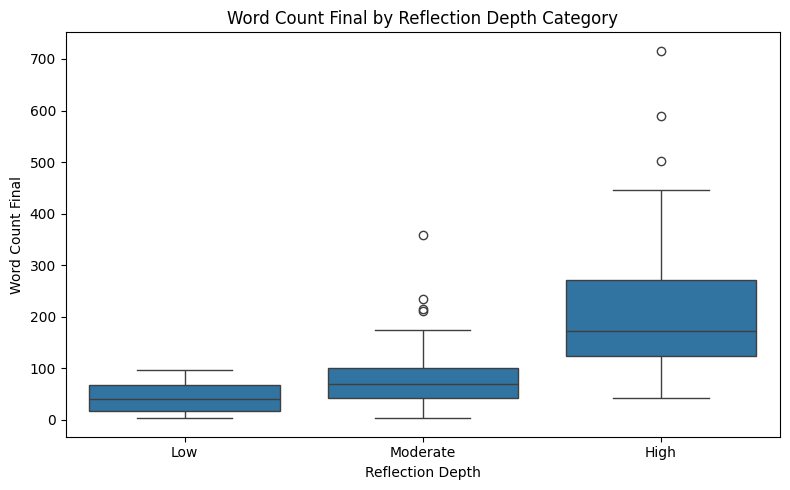

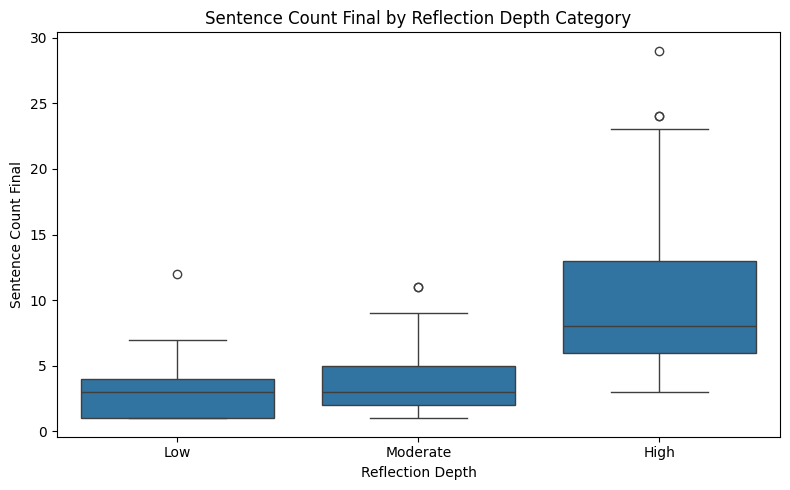

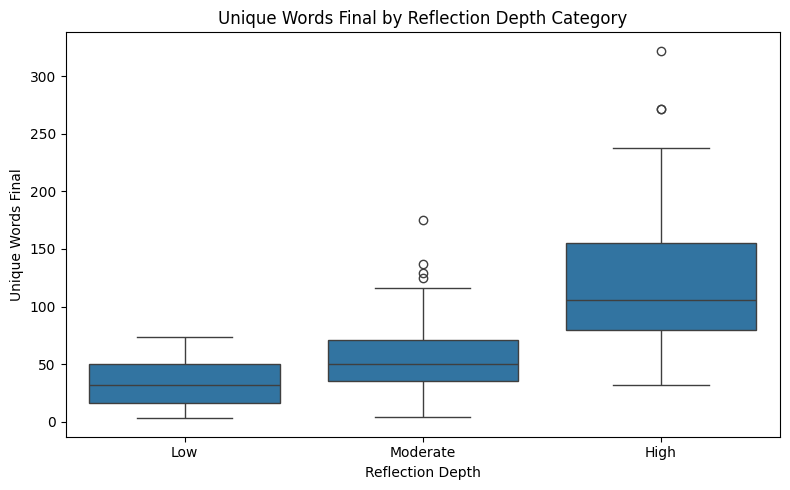

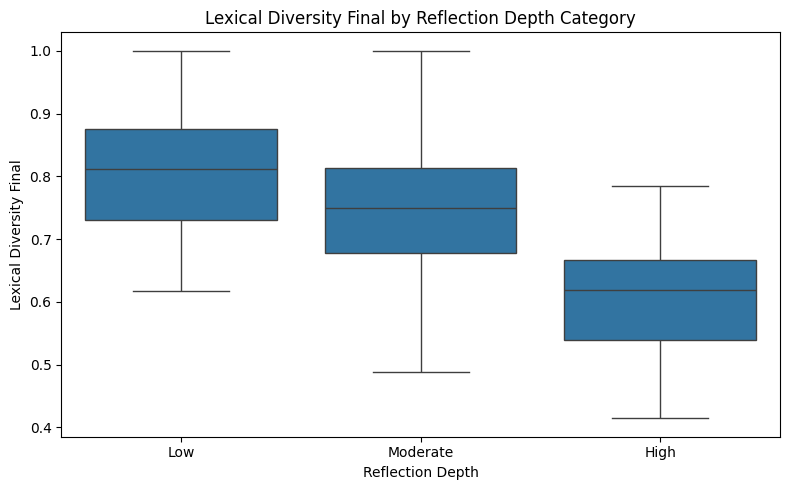

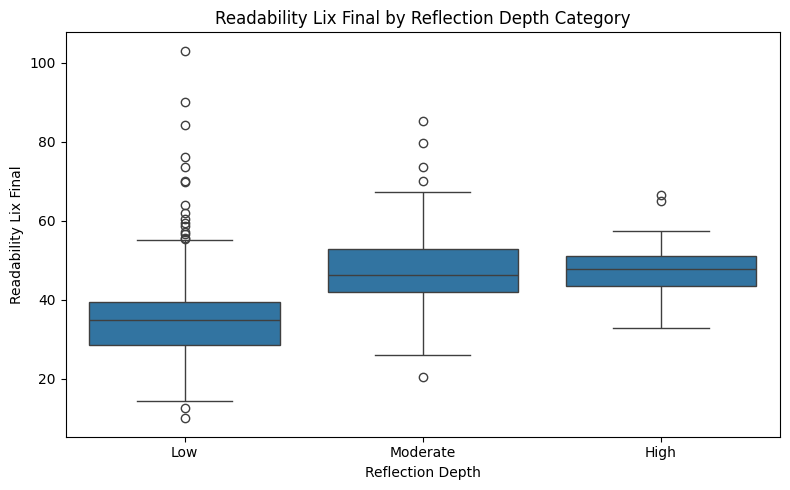

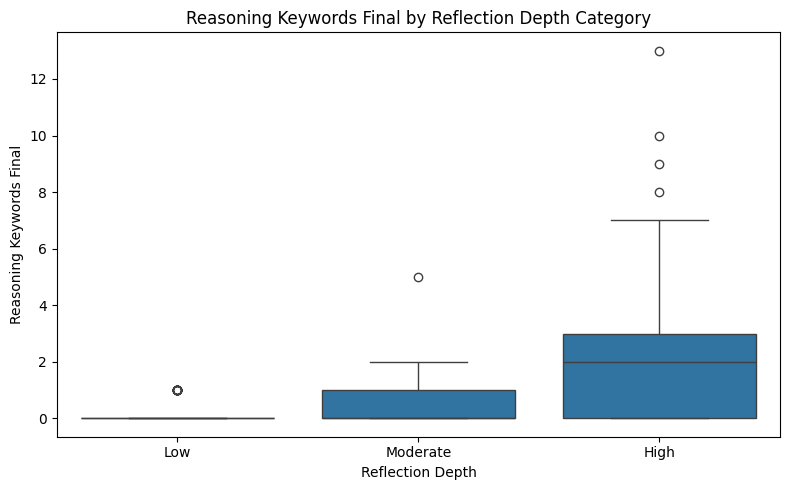

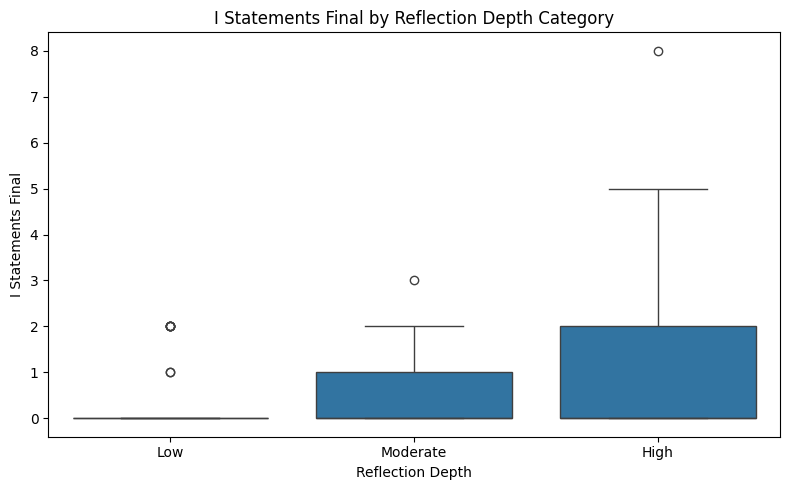

,statistic,p_value
word_count_final,156.581270,9.972619e-35
unique_words_final,154.752347,2.488598e-34
sentence_count_final,136.251233,2.590721e-30
lexical_diversity_final,125.357684,6.010697e-28
reasoning_keywords_final,61.975933,3.484152e-14
readability_lix_final,37.593629,6.865106e-09
i_statements_final,17.234437,1.809629e-04


In [18]:
# List of engineered features to analyze
features = [
    "word_count_final",
    "sentence_count_final",
    "unique_words_final",
    "lexical_diversity_final",
    "readability_lix_final",
    "reasoning_keywords_final",
    "i_statements_final"
]

# Dictionary to store test results
kruskal_results = {}

# test skip identical groups (which break the test)
for feature in features:
    groups = [df[df["depth_category"] == cat][feature].dropna() for cat in ["Low", "Moderate", "High"]]
    
    # Check for minimum size and variance
    if all(len(g) >= 2 for g in groups) and any(g.var() > 0 for g in groups):
        stat, p = kruskal(*groups)
        kruskal_results[feature] = {"statistic": stat, "p_value": p}
    else:
        kruskal_results[feature] = {"statistic": None, "p_value": None}

# Loop through each feature
for feature in features:
    # Boxplot grouped by depth category
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x="depth_category", y=feature, order=["Low", "Moderate", "High"])
    plt.title(f"{feature.replace('_', ' ').title()} by Reflection Depth Category")
    plt.xlabel("Reflection Depth")
    plt.ylabel(feature.replace("_", " ").title())
    plt.tight_layout()
    plt.show()

    # Kruskal-Wallis test
    groups = [df[df["depth_category"] == cat][feature] for cat in ["Low", "Moderate", "High"]]
    stat, p = kruskal(*groups)
    kruskal_results[feature] = {"statistic": stat, "p_value": p}

# Convert results to DataFrame
kruskal_df = pd.DataFrame.from_dict(kruskal_results, orient="index")
kruskal_df = kruskal_df.sort_values("p_value")
display(kruskal_df)

In [22]:
group_means = df.groupby("depth_category")[["word_count_final", "sentence_count_final", "unique_words_final"]].mean()
print(group_means)

                word_count_final  sentence_count_final  unique_words_final
depth_category                                                            
Low                    44.684932              2.863014           34.082192
Moderate               78.872340              3.723404           54.776596
High                  214.185567              9.773196          121.969072


/var/folders/m2/wwp0kh353wlcxjqhp1nyx4xm0000gn/T/ipykernel_25811/72516898.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_means = df.groupby("depth_category")[["word_count_final", "sentence_count_final", "unique_words_final"]].mean()


In [19]:
print(df.columns.tolist())

['topic_title', 'topic_description', 'question', 'reflection_snapshot', 'snapshot_length', 'calc_refl_snap', 'suggestion_content', 'calc_ai_suggest_length', 'final_reflection', 'content_length', 'calc_final_refl', 'length_diff', 'created_at', 'last_reflection_moment', 'seconds_spent', 'suggestion_params', 'topic_title_clean', 'topic_description_clean', 'question_clean', 'reflection_snapshot_clean', 'suggestion_content_clean', 'final_reflection_clean', 'final_length_clean', 'snapshot_length_clean', 'calc_ai_suggest_length_clean', 'length_diff_clean', 'lang_detected', 'word_count_final', 'sentence_count_final', 'unique_words_final', 'lexical_diversity_final', 'readability_lix_final', 'reasoning_keywords_final', 'reasoning_phrases_final', 'i_statements_final', 'depth_score', 'depth_category']


### Snapshot Reflection Feature Engineering

In [20]:
from scipy.stats import spearmanr

# --- Step 1: Feature Engineering for Initial Reflection (snapshot) ---

def extract_snapshot_features(text, lang):
    if not isinstance(text, str) or not text.strip():
        return pd.Series({
            "word_count_snapshot": 0,
            "reasoning_keywords_snapshot": 0,
            "readability_lix_snapshot": 0.0
        })
    
    text_lower = text.lower()
    words = word_tokenize(text_lower)
    tokenizer = language_tokenizers.get(lang, language_tokenizers["en"])
    sentences = tokenizer.tokenize(text)

    word_count = len(words)
    long_words = sum(1 for w in words if len(w) > 6)
    sentence_count = len(sentences)
    lix = word_count / sentence_count + (long_words * 100 / word_count) if sentence_count > 0 else 0

    keyword_set = reasoning_keywords_all.get(lang, reasoning_keywords_all["en"])
    reasoning_word_hits = sum(1 for w in words if w in keyword_set)

    return pd.Series({
        "word_count_snapshot": word_count,
        "reasoning_keywords_snapshot": reasoning_word_hits,
        "readability_lix_snapshot": lix
    })

# Apply feature extraction to snapshots
df[["word_count_snapshot", "reasoning_keywords_snapshot", "readability_lix_snapshot"]] = df.apply(
    lambda row: extract_snapshot_features(row["reflection_snapshot_clean"], row["lang_detected"]),
    axis=1
)

# --- Step 2: Compute Change Metrics ---
df["word_diff"] = df["word_count_final"] - df["word_count_snapshot"]
df["reasoning_keyword_diff"] = df["reasoning_keywords_final"] - df["reasoning_keywords_snapshot"]
df["readability_diff"] = df["readability_lix_final"] - df["readability_lix_snapshot"]

# --- Step 3: Correlation Analysis ---
change_metrics = ["length_diff_clean", "word_diff", "reasoning_keyword_diff", "readability_diff"]
quality_metrics = [
    "word_count_final", "sentence_count_final", "unique_words_final",
    "lexical_diversity_final", "readability_lix_final",
    "reasoning_keywords_final", "i_statements_final"
]

correlation_results = []
for change_var in change_metrics:
    for quality_var in quality_metrics:
        corr, pval = spearmanr(df[change_var], df[quality_var], nan_policy="omit")
        correlation_results.append({
            "change_metric": change_var,
            "quality_metric": quality_var,
            "spearman_rho": corr,
            "p_value": pval
        })

cor_df = pd.DataFrame(correlation_results)

# --- Correlation between change metrics and reflection depth score ---
print("\n🔍 Spearman correlations between change metrics and depth_score:")
for change_var in change_metrics:
    rho, pval = spearmanr(df[change_var], df["depth_score"], nan_policy="omit")
    print(f"{change_var} vs depth_score → Spearman r = {rho:.3f}, p = {pval:.3f}")






🔍 Spearman correlations between change metrics and depth_score:
length_diff_clean vs depth_score → Spearman r = 0.237, p = 0.000
word_diff vs depth_score → Spearman r = 0.251, p = 0.000
reasoning_keyword_diff vs depth_score → Spearman r = 0.274, p = 0.000
readability_diff vs depth_score → Spearman r = -0.025, p = 0.688


### Visualize Spearman Correlations

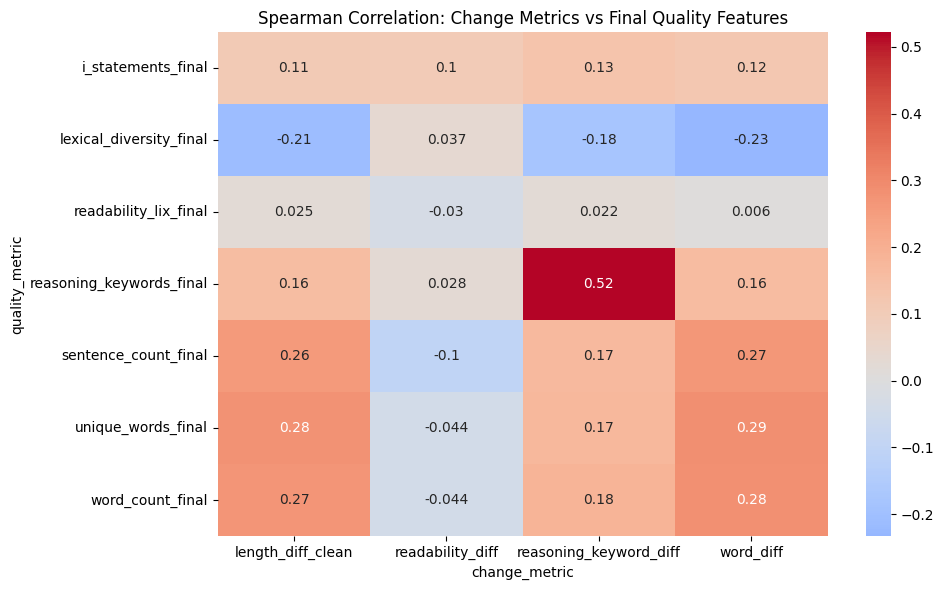

,change_metric,quality_metric,spearman_rho,p_value
19,reasoning_keyword_diff,reasoning_keywords_final,0.521844,7.666768e-20
9,word_diff,unique_words_final,0.288575,1.857228e-06
7,word_diff,word_count_final,0.281506,3.375486e-06
2,length_diff_clean,unique_words_final,0.278976,4.163910e-06
0,length_diff_clean,word_count_final,0.269089,9.272183e-06
8,word_diff,sentence_count_final,0.266964,1.096885e-05
1,length_diff_clean,sentence_count_final,0.256951,2.375486e-05
10,word_diff,lexical_diversity_final,-0.233545,1.282776e-04
3,length_diff_clean,lexical_diversity_final,-0.214878,4.381859e-04
14,reasoning_keyword_diff,word_count_final,0.182788,2.872889e-03


In [21]:
# --- Step 4: Visualize Correlations ---
pivot_df = cor_df.pivot(index="quality_metric", columns="change_metric", values="spearman_rho")

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, cmap="coolwarm", center=0)
plt.title("Spearman Correlation: Change Metrics vs Final Quality Features")
plt.tight_layout()
plt.show()

# Optional: Show top correlations sorted
cor_df["abs_rho"] = cor_df["spearman_rho"].abs()
display(cor_df.sort_values("abs_rho", ascending=False).drop(columns="abs_rho"))